# Of Logs and Bayes, Hams and Spams...
**Classifying E-mails using Logarithmic Regression and Bayes Classification**

- [1 Introduction](#1)
- [2 Reading the Data](#2)
- [3 Logistic, Bayes.. What's all this?](#3)
- [4 Workin' at the Data wash...Yeah!!](#4)
- [5 Once, Twice, Thrice...](#5)
- [6 Probable Probability Problem](#6)
- [7 Round 1: Naive Bayes Classification !!](#7)
- [8 60-30?!... You can do better than that!](#8)
- [9 Round 2: Logistic Regression!!](#9)
- [10 And the Winner is...](#10)
- [11 Conclusion](#11)
- [12 Learnings](#12)

# 1

## Introduction

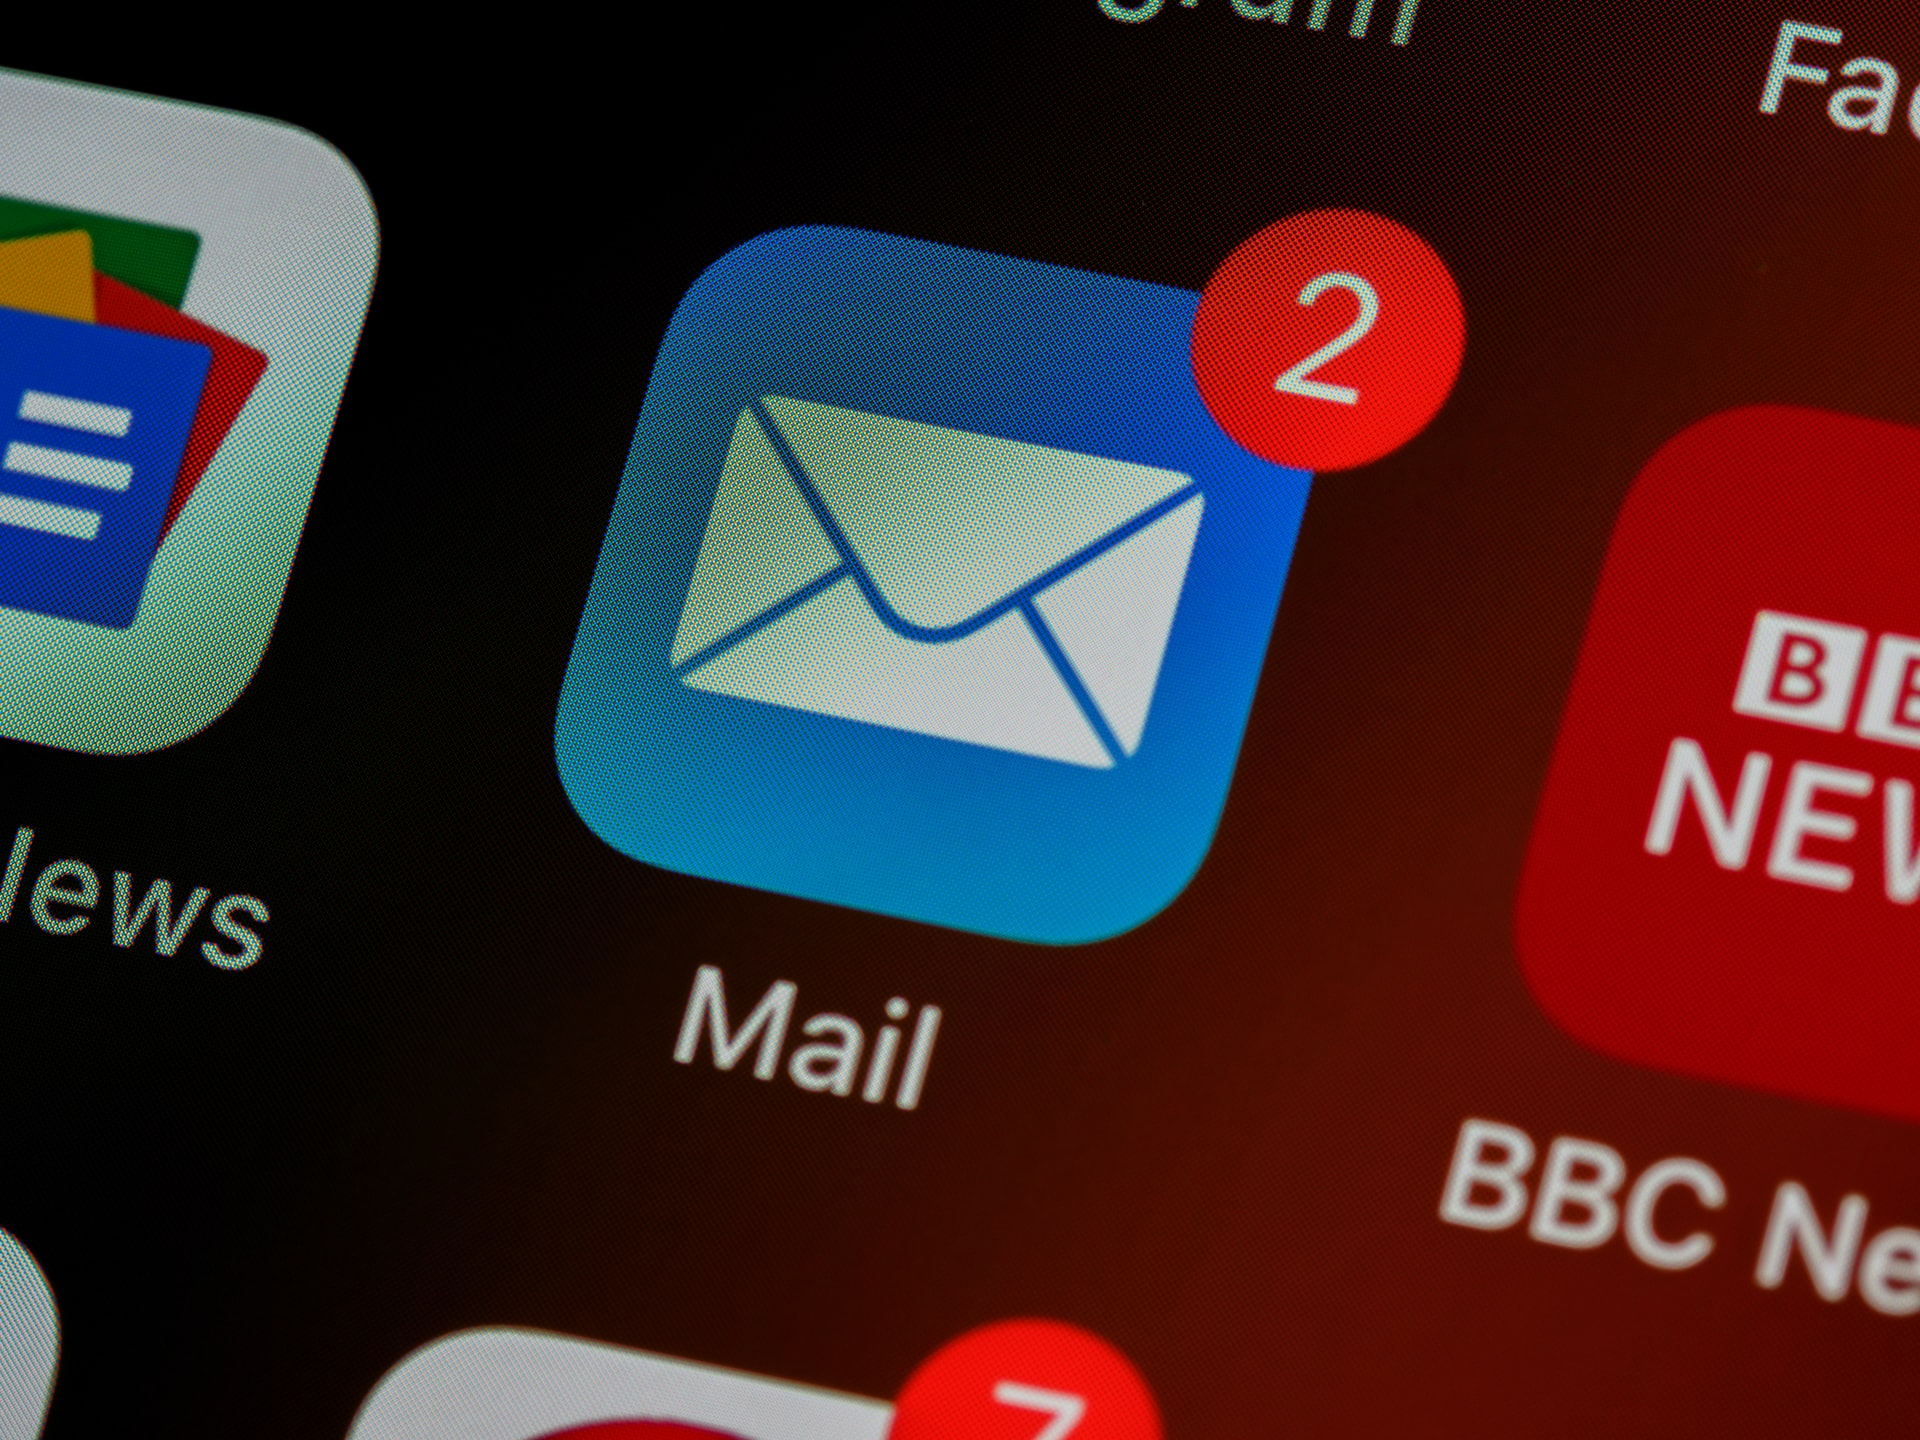
*Source*:[Unsplash](https://unsplash.com/photos/LPZy4da9aRo)

Spam e-mails are an annoyance and in some cases can becomes a security issue. It becomes a security issue when e-mail users actively attend to the links or the directions provided in the spam message.

Identifying such messages can be a challenge especially because the system may be unaware of the difference between ham(valid) and spam messages. 

The rise of data science and machine learning has allowed to identify spam e-mails.
The goal of this project is to use two machine learning models namely, Naive Bayes Classification and Logistic Regression to identify whether an e-mail is spam or ham based on the contents of the:
- Subject section of an e-mail
- Body section of an e-mail

Besides this we will verify the effectiveness of each models based on measurements,such as accuracy, sensitivity and specificity.

[Index](#Index)

# 2

## Reading the Data

The data to be analysed was collected from [Kaggle](https://www.kaggle.com/venky73/spam-mails-dataset).
We shall move forward by first reading the data and analysing the same.

In [189]:
import pandas as pd
import re
from prettytable import PrettyTable
from nltk.corpus import stopwords

emails = pd.read_csv("spam_ham_dataset.csv")
emails.head(5)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [190]:
t = PrettyTable(['Rows','Columns'])
t.add_row([emails.shape[0],emails.shape[1]])
print(t)

+------+---------+
| Rows | Columns |
+------+---------+
| 5171 |    4    |
+------+---------+


In [191]:
t=PrettyTable(['E-mail Classification','Count','%'])
ham_message_count = emails[emails["label_num"]==0].shape[0]
spam_message_count = emails[emails["label_num"]==1].shape[0]

ham_percent = round(ham_message_count/emails.shape[0]*100,2)
spam_percent = round(spam_message_count/emails.shape[0]*100,2)

t.add_row(['Ham', ham_message_count, ham_percent])
t.add_row(['Spam', spam_message_count, spam_percent])
print(t)

+-----------------------+-------+-------+
| E-mail Classification | Count |   %   |
+-----------------------+-------+-------+
|          Ham          |  3672 | 71.01 |
|          Spam         |  1499 | 28.99 |
+-----------------------+-------+-------+


In [192]:
print("\033[1m Sample of\033[0m \033[2mtext\033[0m \033[1mColumn:")
emails["text"].iloc[3]

 Sample of text Column:


'Subject: photoshop , windows , office . cheap . main trending\r\nabasements darer prudently fortuitous undergone\r\nlighthearted charm orinoco taster\r\nrailroad affluent pornographic cuvier\r\nirvin parkhouse blameworthy chlorophyll\r\nrobed diagrammatic fogarty clears bayda\r\ninconveniencing managing represented smartness hashish\r\nacademies shareholders unload badness\r\ndanielson pure caffein\r\nspaniard chargeable levin\r\n'

Based on the analysis above, **71%** of the dataset contains ham e-mails, the rest are spam. Every e-mail has a section for the *subject* of the email and its relative *content*. Since it is not clear of where the subject exactly ends we are going to have to assume that the text till the first new line operator, `\n`, indicates the end of the *Subject*. Whatever, follows thereafter is assumed to be the content of the e-mail.

Based on this understanding we should be able to clearly separate the *subject* and *content* and verify the same.

In [193]:
emails["email_subject"] = emails["text"].str.extract("Subject:(.*?)\\r\\n")
emails["email_body"]=emails["text"].str.extract("(?s)\\r\\n(.*)",expand=True)
emails.head(5)

,Unnamed: 0,label,text,label_num,email_subject,email_body
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,enron methanol ; meter # : 988291,this is a follow up to the note i gave you on ...
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"hpl nom for january 9 , 2001",( see attached file : hplnol 09 . xls )\r\n- h...
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,neon retreat,"ho ho ho , we ' re around to that most wonderf..."
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,"photoshop , windows , office . cheap . main t...",abasements darer prudently fortuitous undergon...
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,re : indian springs,this deal is to book the teco pvr revenue . it...


Before proceeding we could polish the above dataframe so that it is ready for further analysis and cleaning. We shall remove a column and rename another. 

In [194]:
emails.drop(columns=['Unnamed: 0'],inplace=True)
emails.rename(columns={'label_num':'spam_flag'},inplace=True)
emails.head(5)

,label,text,spam_flag,email_subject,email_body
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,enron methanol ; meter # : 988291,this is a follow up to the note i gave you on ...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"hpl nom for january 9 , 2001",( see attached file : hplnol 09 . xls )\r\n- h...
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,neon retreat,"ho ho ho , we ' re around to that most wonderf..."
3,spam,"Subject: photoshop , windows , office . cheap ...",1,"photoshop , windows , office . cheap . main t...",abasements darer prudently fortuitous undergon...
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,re : indian springs,this deal is to book the teco pvr revenue . it...


[Index](#Index)

# 3

## Logistic, Bayes.. What's all this?
**Understanding Naive Bayes Classification and Logistics Regression**

The naive Bayes Classification is based on the [Bayes Theorem](https://www.mathsisfun.com/data/bayes-theorem.html) which stems from the idea of [Conditional Probability](https://www.mathsisfun.com/data/probability-events-conditional.html).

The idea behind Conditional Probability is that the probability of a dependent event A can change based on the dependee event B having already happened. e.g Normally the probability of rolling a 5 on a fair 6 sided die would be 1/6. However, assume the 6 sided die was rolled and it was declared that the outcome of the event is an odd number. The probability that a 5 was rolled becomes 1/3 because we know that an odd number was rolled.

Based on Conditional Probability the principle working behind [naive Bayes Classification](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) for Spam Detection is as follows:

Empirical data can reveal the probability of spam and ham messages. After creating a vocabulary of words associated to ham and spam messages from the existing dataset, we can calculate the probability of those words appearing in those respective message types. The probability of spam messages coming in and they having words associated to spam are the dependent conditions, the same holds for ham messages and its related words.

Armed with these probabilities and combining them during the assessment of a new message, we can identify the degree by which they are associated to spam or ham messages.

If a message should appear with words that do not exist in our current dataset, they are ignored and probabilities are determined using the known words.

The word *naive* is associated to this classification because when calculating the probabilities, it is assumed that the words in the message are independent of each other. The words 'good dog' are treated individually as words 'good' and 'dog' their combined meaning is not taken in to consideration. This is based on the property of [Conditional Independence](https://towardsdatascience.com/conditional-independence-the-backbone-of-bayesian-networks-85710f1b35b
). 

The principle of conditional independence is associated to probability wherein two or more events that are *not independent* become **"conditionally"** independent because of another event. e.g If event A is the amount of a speed fine and B is the type of car that invited such a fine, data may show that high mileage cars invite more fines. However, if event C is the speed the cars traveled in, then the events A and B are conditionally independent because of event C. 

This outcome of a naive bayes classification is a probability value.

[Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) similarly can be used for binary classification though it is not limited to it. The model is associated to what is called a sigmoid function. The function takes in a value and outputs a values that is between 0 and 1. If the value is close to 0, the outcome is considered 0 and if the outcome is close to 1 the outcome is considered 1.
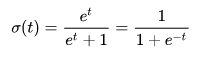
*Source*: [Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression)

Logistic regression is a machine learning model and like any machine learning model, it requires a training data set with which helps it to create a model to fit. Using the model we should be able to predict the outcome of new data.

For detecting spam e-mails we will first calculate the inverse document frequecy of each word in the subject and body section of each mail. After we have these values, we will train and fit a logistic regression model. The model will be using against a test set to predict whether the e-mail in the test set is ham or spam.

[Index](#Index)

# 4

## Workin' at the Data wash...Yeah!!
**Cleaning and preparing data for Bayes Classification**

Before we perform naive Bayes classification, we will need to clean the dataset by removing punctuations and [stop words](https://www.opinosis-analytics.com/knowledge-base/stop-words-explained/#.YbgRmVnhVpg).

In [195]:
eng_stop_words = set(stopwords.words('english'))

In [196]:
def clean_data(the_data):
    
    lower_case = the_data.lower()
    no_punctn = re.sub("\W"," ",lower_case)
    split_data = no_punctn.split()
    
    #Remove stop words
    no_stop_words=[]
    for each_word in split_data:
        if each_word not in eng_stop_words:
            no_stop_words.append(str(each_word))
    return no_stop_words

In [197]:
emails["clean_subject"] = emails["email_subject"].apply(clean_data)
emails["clean_body"] = emails["email_body"].apply(clean_data)
emails.head(5)

,label,text,spam_flag,email_subject,email_body,clean_subject,clean_body
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,enron methanol ; meter # : 988291,this is a follow up to the note i gave you on ...,"[enron, methanol, meter, 988291]","[follow, note, gave, monday, 4, 3, 00, prelimi..."
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"hpl nom for january 9 , 2001",( see attached file : hplnol 09 . xls )\r\n- h...,"[hpl, nom, january, 9, 2001]","[see, attached, file, hplnol, 09, xls, hplnol,..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,neon retreat,"ho ho ho , we ' re around to that most wonderf...","[neon, retreat]","[ho, ho, ho, around, wonderful, time, year, ne..."
3,spam,"Subject: photoshop , windows , office . cheap ...",1,"photoshop , windows , office . cheap . main t...",abasements darer prudently fortuitous undergon...,"[photoshop, windows, office, cheap, main, tren...","[abasements, darer, prudently, fortuitous, und..."
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,re : indian springs,this deal is to book the teco pvr revenue . it...,"[indian, springs]","[deal, book, teco, pvr, revenue, understanding..."


Now that we have columns that refer to the *subject* and *body* of the emails with much less noise we shall proceed to preparing the dataset for the classification. We shall split the dataset in a manner that allows for 80% of it to be used as the training set and the rest will be used as the test set.

In [198]:
#Randomize the data
randomized=emails.sample(frac=1,random_state=1)

#Generate training set and test set
train_set = randomized.iloc[:round(len(randomized) * 0.8)].reset_index(drop=True)
test_set = randomized.iloc[round(len(randomized) * 0.8):].reset_index(drop=True)

Now that we have a training set and a test set, we shall proceed to creating a vocabulary of all the words in the training set and calculating their occurences in spam and ham messages.

[Index](#Index)

# 5

## Once, Twice, Thrice...
**Calculating the occurence of words in ham and spam messages**

In order to calculate the probability of a new message being either ham or spam we first need to know what words appear most commonly in ham and spam messages. For this we need to create a catalogue of the occurences of each word in ham and spam messages.

Since we are attempting to identify ham and spam messages using the subject and body separately, we need to create vocabularies of words that appear in the *subject* section and the *content* section separately. After creating this vocabulary we shall attempt to create a catalogue of their occurences in these sections.

In [199]:
def generate_occurence_catalogue(data_with_label):
    
    #Generate vocabulary
    vocabulary = []
    content = data_with_label.iloc[:,1]
    for each_list in content:
        for each_word in each_list:
            vocabulary.append(each_word)
    vocabulary = list(set(vocabulary))
    
    #Generate occurence catalogue
    occurence_catalogue = {each_word:[0]*len(data_with_label) for each_word in vocabulary}
    for index, the_content in enumerate(content):
        for a_word in the_content:
            occurence_catalogue[a_word][index]+=1
    
    occurence_catalogue = pd.DataFrame(occurence_catalogue)
    vocabulary_length = len(vocabulary)
    return pd.concat([data_with_label,occurence_catalogue],axis=1), vocabulary, vocabulary_length

### Creating occurence catalogue for E-mail Subject

We shall begin by creating an occurence catalogue of all the words in the *subject* section of the e-mail. After this we should be able to separate the occurence catalogue in to two sets. One will contain ham *subjects* along with counts of the words that appear in them while the other will contain spam *subjects* alongside their word counts.

In [200]:
subject_occurence_catalogue, subject_vocabulary, total_words_subject_vocab = generate_occurence_catalogue(train_set[["spam_flag","clean_subject"]])
subject_occurence_catalogue.head(3)

,spam_flag,clean_subject,acts,sp,depression,dana,links,rangel,loans,high,...,debt,reduction,update,alert,central,doesnt,undiscovered,16,lindholm,laid
0,0,[heck],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,"[hilcorp, old, ocean, volume]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,"[jurirne, get, latest, softwares, 99, savings,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Creating occurence catalogue for E-mail body

As we have done above we shall create an occurence catalogue of all the words that appear in the e-mail body.

In [201]:
body_occurence_catalogue, body_vocabulary, total_words_body_vocab = generate_occurence_catalogue(train_set[["spam_flag","clean_body"]])
body_occurence_catalogue.head(3)

,spam_flag,clean_body,ltglxktzb,6519,inquired,tillage,mandey,estimated,armata,532,...,medications,stabs,hamilton,sergio,0001,toniandmikeg,repertoire,diaper,shard,ancing
0,0,"[daren, see, ken, back, jeff, development, jef...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,"[according, gary, hanks, would, like, gas, val...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,"[microsoft, windows, xp, professional, 50, ado...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that we know the occurences of each word in the vocabulary in every e-mail and also know the e-mails identified as ham or spam, we can split the dataframes created above based on the message type i.e. ham and spam

In [202]:
subject_ham = subject_occurence_catalogue[subject_occurence_catalogue['spam_flag']==0]
subject_spam = subject_occurence_catalogue[subject_occurence_catalogue['spam_flag']==1]

body_ham = body_occurence_catalogue[body_occurence_catalogue['spam_flag']==0]
body_spam = body_occurence_catalogue[body_occurence_catalogue['spam_flag']==1]

[Index](#Index)

# 6

## Probable Probability Problem
**Calculating the probability of each word in ham and spam messages**

The naive Bayes Classification for Spam Detection is based on the following formulae:

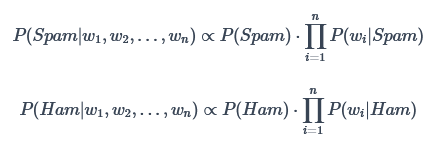
*Source*:[Dataquest.io](https://app.dataquest.io/c/74/m/432/the-naive-bayes-algorithm/12/next-steps)

As mentioned earlier, the probabilities are being calculated to determine based on the combination of the probability of the words in the message and the probability of the message itself being ham or spam. However in order to calculate this we need to find the probability of ham and spam messages in the dataset and then the probability of the words appearing in those messages. 

The next formula will aid in determining the probability of the words appearing in a message depending on whether they are ham or spam messages.

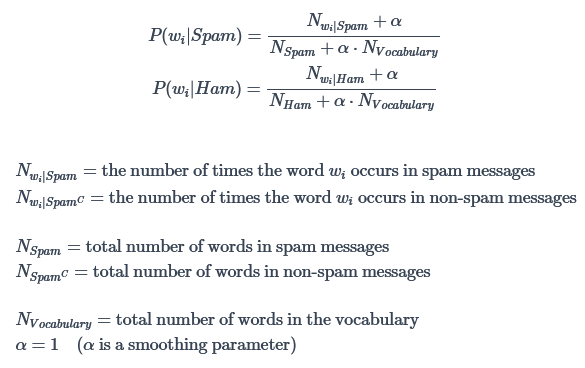
*Source*:[Dataquest.io](https://app.dataquest.io/c/74/m/432/the-naive-bayes-algorithm/12/next-steps)

Based on the above there are a few constants that can be calculated before hand which include:
- `P(ham)`
- `P(spam)`
- `N`<sub>Spam</sub>
- `N`<sub>Spam<sup>C</sup></sub>
- `N`<sub>Vocabulary</sub>
- `α` is the smoothing parameter that will be used for [additive smoothing](https://en.wikipedia.org/wiki/Additive_smoothing)

It must be noted that we need to separately calculate N<sub>Spam</sub> ,N<sub>Spam<sup>C</sup></sub> , N<sub>Vocabulary</sub> for *clean_subject* and *clean_body*. We shall begin by calculating probabilities for *clean_subject* column.

### Calculating Probabilities for words in E-mail Subject

In [203]:
total_num_emails = len(emails)
num_ham_emails = (emails['spam_flag']==0).sum()
num_spam_emails = (emails['spam_flag']==1).sum()

#Calculate P(ham) and P(spam)
p_ham = num_ham_emails/total_num_emails
p_spam = num_spam_emails/total_num_emails

#Calculate total number of words in subject section of ham and spam e-mails
total_subject_ham_words = subject_ham.iloc[:,2:].sum(axis=0).sum() 
total_subject_spam_words = subject_spam.iloc[:,2:].sum(axis=0).sum()

#Total vords in vocabulary calculated earlier and stored in the variable total_words_subject_vocab

alpha=1

Now that we have the necessary constants we can calculate the probability of each word appearing in both ham and spam messages.

In [204]:
def calculate_word_probability(word,occurence_catalogue,total_words,vocab_total_words):
    word_probability = (occurence_catalogue[word].sum()+alpha)/(total_words+alpha*vocab_total_words)
    return word_probability

In [205]:
word_probability_ham_subject = {}
word_probability_spam_subject = {}

for each_word in subject_vocabulary:
    word_probability_ham_subject[each_word] = calculate_word_probability(each_word,
                                                                         subject_ham,
                                                                         total_subject_ham_words,
                                                                         total_words_subject_vocab)
    
    word_probability_spam_subject[each_word] = calculate_word_probability(each_word,
                                                                          subject_spam,
                                                                          total_subject_spam_words,
                                                                          total_words_subject_vocab)

### Calculating Probabilities for words in E-mail Body

As mentioned earlier, we need to separately calculate N<sub>Spam</sub> ,N<sub>Spam<sup>C</sup></sub> , N<sub>Vocabulary</sub> for the e-mail body section

In [206]:
#Calculate total number of words in body section of ham and spam e-mails
total_body_ham_words = body_ham.iloc[:,2:].sum(axis=0).sum() 
total_body_spam_words = body_spam.iloc[:,2:].sum(axis=0).sum()

#Total vords in vocabulary calculated earlier and stored in the variable total_words_body_vocab

In [207]:
word_probability_ham_body = {}
word_probability_spam_body = {}

for each_word in body_vocabulary:
    word_probability_ham_body[each_word] = calculate_word_probability(each_word,
                                                                      body_ham,
                                                                      total_body_ham_words,
                                                                      total_words_body_vocab)
    
    word_probability_spam_body[each_word] = calculate_word_probability(each_word,
                                                                       body_spam,
                                                                       total_body_spam_words,
                                                                       total_words_body_vocab)

Now that we have all the necessary values required to calculate the probabilities of a word being in either ham or spam e-mail messages, we can calculate the probability of a new message being either ham or spam.

[Index](#Index)

# 7

## Round 1: Naive Bayes Classification !!
**Classifying e-mails as ham or spam using naive Bayes Classification**

Using the test set data we created earlier we can now verify how effective Bayes classification is in identifying ham and spam e-mails using the subject and body section independently. We shall begin with analysing the subject section of the e-mails in the test set.

### Identifying Ham and Spam E-mails from the Subject

In [208]:
probability_ham = num_ham_emails/total_num_emails
probability_spam = num_spam_emails/total_num_emails

In [209]:
def classify(message,vocabulary,ham_probabilities,spam_probabilities):
    message_ham_probability = probability_ham
    message_spam_probability = probability_spam
    for each_word in message:
        if each_word in vocabulary:
            message_ham_probability*=ham_probabilities[each_word]
            message_spam_probability*=spam_probabilities[each_word]
    
    if message_ham_probability > message_spam_probability:
        return 0
    elif message_ham_probability < message_spam_probability:
        return 1
    else:
        return 5

In [210]:
test_set_condensed = test_set[['spam_flag','clean_subject']].copy()
test_set_condensed['prediction'] = test_set_condensed['clean_subject'].apply(classify,
                                                                             args=(subject_vocabulary,
                                                                                   word_probability_ham_subject,
                                                                                   word_probability_spam_subject))
test_set_condensed.head(5)

,spam_flag,clean_subject,prediction
0,0,"[enron, hpl, actuals, june, 15, 2000]",0
1,1,"[anouncing, new, player, market, qbbcpryhrv]",1
2,0,"[republic, royalty, 5, 00]",0
3,1,"[instructions, remove, spyware, adware, infect...",1
4,1,"[90, discounts, microsoft, adobe, autodesk, co...",1


In [211]:
t=PrettyTable(['Predicted Classification','Count','%'])
ham_message_count = test_set_condensed[test_set_condensed['prediction']==0].shape[0]
spam_message_count = test_set_condensed[test_set_condensed['prediction']==1].shape[0]
human_reqd = test_set_condensed[test_set_condensed['prediction']==5].shape[0]

ham_percent = round(ham_message_count/test_set_condensed.shape[0]*100,2)
spam_percent = round(spam_message_count/test_set_condensed.shape[0]*100,2)
human_percent = round(human_reqd/test_set_condensed.shape[0]*100,2)

t.add_row(['Ham', ham_message_count, ham_percent])
t.add_row(['Spam', spam_message_count, spam_percent])
t.add_row(['Unsure', human_reqd, human_percent])
print(t)

+--------------------------+-------+-------+
| Predicted Classification | Count |   %   |
+--------------------------+-------+-------+
|           Ham            |  800  | 77.37 |
|           Spam           |  233  | 22.53 |
|          Unsure          |   1   |  0.1  |
+--------------------------+-------+-------+


In [212]:
def cal_sensitivity(flag_and_prediction):
    true_positive = ((flag_and_prediction.iloc[:,0]==1)&(flag_and_prediction.iloc[:,1]==1)).sum()
    false_negative = ((flag_and_prediction.iloc[:,0]==1)&(flag_and_prediction.iloc[:,1]==0)).sum()
    sensitivity = round((true_positive/(true_positive+false_negative))*100,2)
    return sensitivity

In [213]:
def cal_specificity(flag_and_prediction):
    true_negative = ((flag_and_prediction.iloc[:,0]==0)&(flag_and_prediction.iloc[:,1]==0)).sum()
    false_positive = ((flag_and_prediction.iloc[:,0]==0)&(flag_and_prediction.iloc[:,1]==1)).sum()
    specificity = round((true_negative/(true_negative+false_positive))*100,2)
    return specificity

In [214]:
t=PrettyTable(['Prediction Accuracy','Count','%'])
correct_prediction = test_set_condensed[test_set_condensed['prediction']==test_set_condensed['spam_flag']].shape[0]
incorrect_prediction = test_set_condensed[test_set_condensed['prediction']!=test_set_condensed['spam_flag']].shape[0]

bayes_subject_accuracy = round(correct_prediction/test_set_condensed.shape[0]*100,2)
incorrect_percent = round(incorrect_prediction/test_set_condensed.shape[0]*100,2)

bayes_subject_sensitivity = cal_sensitivity(test_set_condensed[['spam_flag','prediction']])
bayes_subject_specificity = cal_specificity(test_set_condensed[['spam_flag','prediction']])

t.add_row(['Correct', correct_prediction, bayes_subject_accuracy])
t.add_row(['Incorrect', incorrect_prediction, incorrect_percent])
print(bayes_subject_sensitivity,bayes_subject_specificity)
print(t)

73.17 96.92
+---------------------+-------+-------+
| Prediction Accuracy | Count |   %   |
+---------------------+-------+-------+
|       Correct       |  933  | 90.23 |
|      Incorrect      |  101  |  9.77 |
+---------------------+-------+-------+


Based on the above findings, the algorithim failed to classify a single e-mail as either ham or spam. Of those that were classified nearly **10%** was incorrectly classified. This means that 1 out of every 10 e-mails could be incorrectly classified which seems to be a very good statistic.

We shall next examine the analysis when the body section of the e-mails undergo the same classification procedure.

### Identifying Ham and Spam E-mails from the E-mail Body

In [215]:
test_set_condensed = test_set[['spam_flag','clean_body']].copy()
test_set_condensed['prediction'] = test_set_condensed['clean_body'].apply(classify,
                                                                             args=(body_vocabulary,
                                                                                   word_probability_ham_body,
                                                                                   word_probability_spam_body))
test_set_condensed.head(5)

,spam_flag,clean_body,prediction
0,0,"[teco, tap, 115, 000, hpl, iferc, 10, 000, enr...",0
1,1,"[trouble, reading, e, mail, click, registratio...",1
2,0,"[done, daren, j, farmer, ect, 06, 29, 2000, 01...",5
3,1,"[message, inform, remove, spyware, adware, pcs...",5
4,1,"[microsoft, windows, xp, professional, 2002, 5...",5


In [216]:
t=PrettyTable(['Predicted Classification','Count','%'])
ham_message_count = test_set_condensed[test_set_condensed['prediction']==0].shape[0]
spam_message_count = test_set_condensed[test_set_condensed['prediction']==1].shape[0]
human_reqd = test_set_condensed[test_set_condensed['prediction']==5].shape[0]

ham_percent = round(ham_message_count/test_set_condensed.shape[0]*100,2)
spam_percent = round(spam_message_count/test_set_condensed.shape[0]*100,2)
human_percent = round(human_reqd/test_set_condensed.shape[0]*100,2)

t.add_row(['Ham', ham_message_count, ham_percent])
t.add_row(['Spam', spam_message_count, spam_percent])
t.add_row(['Unsure', human_reqd, human_percent])
print('\033[1m'+'Predicted Classification of e-mails based on E-mail body'+'\033[0m')
print(t)

Predicted Classification of e-mails based on E-mail body
+--------------------------+-------+------+
| Predicted Classification | Count |  %   |
+--------------------------+-------+------+
|           Ham            |  546  | 52.8 |
|           Spam           |  183  | 17.7 |
|          Unsure          |  305  | 29.5 |
+--------------------------+-------+------+


In [217]:
t=PrettyTable(['Prediction Accuracy','Count','%'])
correct_prediction = test_set_condensed[test_set_condensed['prediction']==test_set_condensed['spam_flag']].shape[0]
incorrect_prediction = test_set_condensed[test_set_condensed['prediction']!=test_set_condensed['spam_flag']].shape[0]

correct_percent = round(correct_prediction/test_set_condensed.shape[0]*100,2)
incorrect_percent = round(incorrect_prediction/test_set_condensed.shape[0]*100,2)

bayes_body_sensitivity = cal_sensitivity(test_set_condensed[['spam_flag','prediction']])
bayes_body_specificity = cal_specificity(test_set_condensed[['spam_flag','prediction']])
print(bayes_body_sensitivity,bayes_body_specificity)

t.add_row(['Correct', correct_prediction, correct_percent])
t.add_row(['Incorrect', incorrect_prediction, incorrect_percent])
print('\033[1m'+'Spam detection accuracy using E-mail Subject'+'\033[0m')
print(t)

87.32 99.24
Spam detection accuracy using E-mail Subject
+---------------------+-------+------+
| Prediction Accuracy | Count |  %   |
+---------------------+-------+------+
|       Correct       |  699  | 67.6 |
|      Incorrect      |  335  | 32.4 |
+---------------------+-------+------+


In [218]:
t=PrettyTable(['Prediction Accuracy','Count','%'])
correct_prediction = (test_set_condensed['prediction']==test_set_condensed['spam_flag']).sum()
incorrect_prediction = ((test_set_condensed['prediction']!=test_set_condensed['spam_flag'])&(test_set_condensed['prediction']!=5)).sum()
unknown = ((test_set_condensed['prediction']!=test_set_condensed['spam_flag'])&(test_set_condensed['prediction']==5)).sum()

bayes_body_accuracy = round(correct_prediction/test_set_condensed.shape[0]*100,2)
incorrect_prediction_percent = round(incorrect_prediction/test_set_condensed.shape[0]*100,2)
unknown_prediction_percent = round(unknown/test_set_condensed.shape[0]*100,2)
print()

t.add_row(['Correct', correct_prediction, bayes_body_accuracy])
t.add_row(['Incorrect', incorrect_prediction, incorrect_prediction_percent])
t.add_row(['Unable to classify', unknown, unknown_prediction_percent])
print('\033[1m'+'Spam detection accuracy using E-mail Body'+'\033[0m')
print(t)


Spam detection accuracy using E-mail Body
+---------------------+-------+------+
| Prediction Accuracy | Count |  %   |
+---------------------+-------+------+
|       Correct       |  699  | 67.6 |
|      Incorrect      |   30  | 2.9  |
|  Unable to classify |  305  | 29.5 |
+---------------------+-------+------+


Based on the above findings, the algorithm failed to correctly classify slightly more than 30% of the e-mails when running Bayes Classification on the body of the e-mails. We can safely assume that the 30% is most contributed by the algorithm's inability to correcly classify the e-mail messages used in the test set. We shall analyse this further

[Index](#Index)

# 8

## 60-30?!... You can do better than that!
**Analysing classification failures when using E-mail Body**

Since more than 1/3<sup>rd</sup> of the e-mails failed to be classified when running the Bayes classification on the subject section of the e-mails, we need to assess why they failed. We shall exclusively focus on the e-mails that failed to classify as either ham or spam

In [219]:
#Identify e-mails that were not classified
failed_classify=test_set[(test_set_condensed['prediction']!=test_set_condensed['spam_flag'])&(test_set_condensed['prediction']==5)][['label','clean_body']].copy()

In [220]:
def more_info(message):
    message_ham_probability = probability_ham
    message_spam_probability = probability_spam
    vocabulary_occurence = 0
    for each_word in message:
        if each_word in body_vocabulary:
            message_ham_probability*=word_probability_ham_body[each_word]
            message_spam_probability*=word_probability_spam_body[each_word]
            vocabulary_occurence+=1
    return pd.Series([round(vocabulary_occurence/len(message)*100,2),message_ham_probability,message_spam_probability],index=['vocabulary_coverage(%)','p_ham','p_spam'])

In [221]:
value=pd.concat([failed_classify,failed_classify['clean_body'].apply(more_info)],axis=1)
value

,label,clean_body,vocabulary_coverage(%),p_ham,p_spam
2,ham,"[done, daren, j, farmer, ect, 06, 29, 2000, 01...",100.00,0.0,0.0
3,spam,"[message, inform, remove, spyware, adware, pcs...",96.97,0.0,0.0
4,spam,"[microsoft, windows, xp, professional, 2002, 5...",93.81,0.0,0.0
7,ham,"[yes, taken, care, future, need, devise, sort,...",100.00,0.0,0.0
9,spam,"[technical, specifications, system, motherboar...",95.05,0.0,0.0
...,...,...,...,...,...
1013,spam,"[87, 00, high, speed, 802, 11, g, 4, port, wir...",97.76,0.0,0.0
1015,spam,"[hi, paliourg, comfort, convenience, prime, co...",99.31,0.0,0.0
1017,spam,"[multi, part, message, mime, format, _, 001, _...",86.90,0.0,0.0
1021,ham,"[daren, please, forward, suzanne, calcagno, si...",100.00,0.0,0.0


In [222]:
print(value.iloc[1,1])

['message', 'inform', 'remove', 'spyware', 'adware', 'pcs', 'hard', 'drive', 'please', 'read', 'carefully', 'someone', 'else', 'uses', 'pc', 'downloading', 'internet', 'files', 'music', 'games', 'movies', 'adware', 'spyware', 'programs', 'may', 'added', 'computer', 'hard', 'drive', 'without', 'direct', 'knowledge', 'check', 'adware', 'spyware', 'applications', 'press', 'cost', 'scan', 'completing', 'complimentary', 'scan', 'brought', 'attention', 'computer', 'hard', 'drive', 'infected', 'adware', 'spyware', 'may', 'computer', 'best', 'interest', 'remove', 'adware', 'spyware', 'applications', 'click', 'begin', 'scan', 'fact', 'currently', '78', '000', 'spyware', 'adware', 'programs', 'internet', 'infect', 'pc', 'chances', 'machine', 'hosting', 'spyware', '9', 'warning', 'signs', 'aware', 'pertain', 'pc', 'likely', 'infected', 'press', 'read', '9', 'warning', 'signs', 'adams', 'acres', 'marketing', 'inc', '16323', 'w', 'abbott', 'rd', 'cairo', 'ne', '68824']


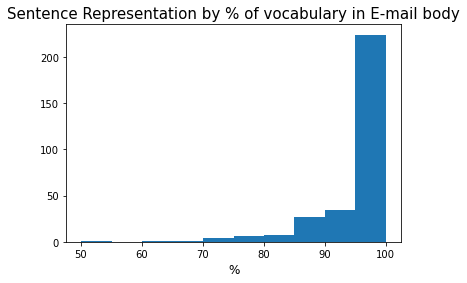

In [223]:
import matplotlib.pyplot as plt
plt.hist(value['vocabulary_coverage(%)'],bins=10)
plt.xlabel('%',size=12)
plt.title("Sentence Representation by % of vocabulary in E-mail body",size=15)
plt.show()

The above histogram clearly shows that most of the test e-mails have nearly all of the words in their *body* section in the *body* vocabulary. So we can be sure that all the words have clear representation in the vocabulary. However due to a large mix of words in the body section of each e-mail, none of the words have a significant representation is all the test e-mails causing their overall probabilities to plummet so significantly that they are rounded to 0.

[Index](#Index)

# 9

## Round 2: Logistic Regression!!
**Classifying e-mails using Logistic Regression**

As we did earlier for Bayes classification we shall analyse the e-mail subject and body separately. We shall begin with analysing the *subject* section of the e-mails.

### Identifying Ham and Spam E-mails from the Subject

Since we are using the [TfidfVectorizer class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), a alot of the cleaning process required for Bayes classification can be completely skipped as the class has parameters which when enabled ensure that
- only words are considered
- stop words are avoided
- all words are in lower case

We shall be calculating the Inverse Document Frequency(IDF) of each word that appears in the dataset and then use the same to train the dataset.

In [224]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase=True,stop_words="english")
subject_vectorized = vectorizer.fit_transform(emails["email_subject"])

Now that we have IDF values we can proceed to splitting the existing dataset to training and test set while ensuring the 80% of the dataset is used for training and the remaining 20% is used for testing.

In [225]:
from sklearn.model_selection import train_test_split
train_subject, test_subject, train_ham_spam, test_ham_spam = train_test_split(subject_vectorized,
                                                                              emails["spam_flag"],
                                                                              test_size=0.2,
                                                                              random_state=5)

Since we now have a training set and a test set, we can proceed to fit the data in to a logistic regression model and follow with attempting to predict the accuracy of the model.

In [226]:
from sklearn.linear_model import LogisticRegression
subject_model = LogisticRegression()
subject_model.fit(train_subject, train_ham_spam)
predictions = subject_model.predict(test_subject)

In [227]:
predictions = pd.Series(predictions)
test_ham_spam.reset_index(drop=True, inplace=True)
subject_output=pd.concat([test_ham_spam,predictions],axis=1)
subject_output.rename(columns={0:'predictions'},inplace=True)

In [228]:
correct_prediction = (subject_output['spam_flag']==subject_output['predictions']).sum()
logistic_subject_accuracy = round(correct_prediction/len(subject_output)*100,2)
wrong_prediction = (subject_output['spam_flag']!=subject_output['predictions']).sum()
wrong_percent = round(wrong_prediction/len(subject_output)*100,2)

logistic_subject_sensitivity = cal_sensitivity(subject_output[['spam_flag','predictions']])
logistic_subject_specificity = cal_specificity(subject_output[['spam_flag','predictions']])

In [229]:
t=PrettyTable(['Prediction Accuracy','Count','%'])
t.add_row(['Correct', correct_prediction, logistic_subject_accuracy])
t.add_row(['Incorrect', wrong_prediction, wrong_percent])
print('\033[1m'+'Spam detection accuracy using E-mail Subject'+'\033[0m')
print(t)

Spam detection accuracy using E-mail Subject
+---------------------+-------+-------+
| Prediction Accuracy | Count |   %   |
+---------------------+-------+-------+
|       Correct       |  939  | 90.72 |
|      Incorrect      |   96  |  9.28 |
+---------------------+-------+-------+


Interestingly, both Bayes Classification and Logistic regression are able to produce with about **90%** whether an e-mail is spam or ham. We shall verify whether the same holds true for the body section of each message.

### Identifying Ham and Spam E-mails from the E-mail Body

Next we shall analyse the e-mail body of the test set and attempt to calculate the accuracy of the logistic regression model.

In [230]:
emails["email_body"] = emails["email_body"].str.replace("\r\n",' ')
content_vectorized = vectorizer.fit_transform(emails["email_body"])

In [231]:
train_content, test_content, train_ham_spam, test_ham_spam = train_test_split(content_vectorized,
                                                                              emails["spam_flag"],
                                                                              test_size=0.2,
                                                                              random_state=5)

In [232]:
content_model = LogisticRegression()
content_model.fit(train_content, train_ham_spam)
predictions = content_model.predict(test_content)

In [233]:
predictions = pd.Series(predictions)
test_ham_spam.reset_index(drop=True, inplace=True)
body_output=pd.concat([test_ham_spam,predictions],axis=1)
body_output.rename(columns={0:'predictions'},inplace=True)

In [234]:
correct_prediction = (body_output['spam_flag']==body_output['predictions']).sum()
logistic_body_accuracy = round(correct_prediction/len(body_output)*100,2)
wrong_prediction = (body_output['spam_flag']!=body_output['predictions']).sum()
wrong_percent = round(wrong_prediction/len(body_output)*100,2)

logistic_body_sensitivity = cal_sensitivity(body_output[['spam_flag','predictions']])
logistic_body_specificity = cal_specificity(body_output[['spam_flag','predictions']])

In [235]:
t=PrettyTable(['Prediction Accuracy','Count','%'])
t.add_row(['Correct', correct_prediction, logistic_body_accuracy])
t.add_row(['Incorrect', wrong_prediction, wrong_percent])
print('\033[1m'+'Spam detection accuracy using E-mail Body'+'\033[0m')
print(t)

Spam detection accuracy using E-mail Body
+---------------------+-------+-------+
| Prediction Accuracy | Count |   %   |
+---------------------+-------+-------+
|       Correct       |  1027 | 99.23 |
|      Incorrect      |   8   |  0.77 |
+---------------------+-------+-------+


Our assumption has proved wrong! Using logistic regression, spam classification seems to be extremely accurate for this dataset when classifying using the e-mail body.

[Index](#Index)

# 10

## And the Winner is...
**Summarizing the results of the classifications**

Now that we've been able to apply both types of classification, we should be able to summarize the result with better evaluation parameters than accuracy, like sensitivity and specificity. From the perspective of the dataset we have been assessing,

- *Sensitivity* highlights the percentage of e-mails that were correctly predicited as spam versus what was observed.
- *Specificity* hightlights the percentage of e-mails that were correctly predicted as ham versus what was observed.

**Sensitivity** is calculated using the formula:
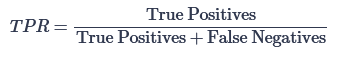
*Source*:[Dataquest](https://app.dataquest.io/c/11/m/22/introduction-to-evaluating-binary-classifiers/5/sensitivity)

Where *TPR* stands for True Positive Rate which is Sensitivity.
- *True Positives* represent all e-mails that were spam and predicted as such
- *False Negatives* represent all e-mails that were spam but predicted as ham

**Specificity** is calculates using the formula:
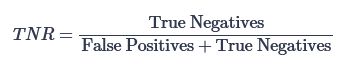
*Source*:[Dataquest](https://app.dataquest.io/c/11/m/22/introduction-to-evaluating-binary-classifiers/6/specificity)

Where *TNR* stands for True Negative Rate which is Specificity.
- *True Negatives* represent all e-mails that were ham and predicted as such.
- *False Positives* represent all e-mails that were ham but predicted as spam.

Sensitiviy and Specificity help to determine how well a binary model classification performs with respect to new data. Using these evaluation parameters we can determine how well a model can correctly identify spam e-mails and how well it can detect ham e-mails.

We shall assess these evaluation parameter for naive Bayes classification and Logistical Regression.

In [243]:
from beautifultable import BeautifulTable
from termcolor import colored

subtable0 = BeautifulTable()
subtable0.rows.header=['']
subtable0.rows.header.separator = ' '
subtable0.rows.append([colored('Bayes\nClassification','red')])
subtable0.rows.append([colored('Logistic\nRegression','blue')])
subtable0.border.left = ''
subtable0.border.right = ''
subtable0.border.top = ''

subtable1 = BeautifulTable()
subtable1.rows.append(['Accuracy %','Sensitivity %','Specificity %'])
subtable1.rows.append([colored(bayes_subject_accuracy,'red'),colored(bayes_subject_sensitivity,'red'),colored(bayes_subject_specificity,'red')])
subtable1.rows.append([colored(logistic_subject_accuracy,'blue'),colored(logistic_subject_sensitivity,'blue'),colored(logistic_subject_specificity,'blue')])
subtable1.columns.padding_left[0] = 0
subtable1.columns.padding_right[0] = 0

subtable2 = BeautifulTable()
subtable2.rows.append(['Accuracy %','Sensitivity %','Specificity %'])
subtable2.rows.append([colored(bayes_body_accuracy,'red'),colored(bayes_body_sensitivity,'red'),colored(bayes_body_specificity,'red')])
subtable2.rows.append([colored(logistic_body_accuracy,'blue'),colored(logistic_body_sensitivity,'blue'),colored(logistic_body_specificity,'blue')])
subtable2.columns.padding_left[0] = 0
subtable2.columns.padding_right[0] = 0
parenttable = BeautifulTable()
parenttable.columns.header = ['','E-mail Subject','E-mail Body']

parenttable.rows.append([subtable0,subtable1,subtable2])
parenttable.columns.padding_left[0] = 0
parenttable.columns.padding_right[0] = 0
print('\033[1m'+'Comparative Evaluation of Bayes Classification and Logistic Regression for the dataset provided'+'\033[0m')
print(parenttable)

Comparative Evaluation of Bayes Classification and Logistic Regression for the dataset provided
+----------------+------------------------------+------------------------------+
|                |        E-mail Subject        |         E-mail Body          |
+----------------+------------------------------+------------------------------+
|                | +-----+---------+----------+ | +-----+---------+----------+ |
|----------------| |Accur| Sensiti | Specific | | |Accur| Sensiti | Specific | |
|     Bayes      | |acy %| vity %  |  ity %   | | |acy %| vity %  |  ity %   | |
| Classification | +-----+---------+----------+ | +-----+---------+----------+ |
|----------------| |90.23|  73.17  |  96.92   | | |67.6 |  87.32  |  99.24   | |
|    Logistic    | +-----+---------+----------+ | +-----+---------+----------+ |
|   Regression   | |90.72|  71.22  |  97.89   | | |99.23|  100.0  |  98.94   | |
|----------------| +-----+---------+----------+ | +-----+---------+----------+ |
+------------

**Insights**:
- Model performance while detecting spam using the E-mail Subject:
    - Both Bayes classification and Logistic Regression have almost the same out put with regards to accuracy in detecting ham and spam
    - The above observation also holds ground for the evaulation parameters such as sensitivity and specificity. It is notable however that Bayes classification holds a slight advantage with regards to detecting spam using the e-mail subject alone considering its sensitivity.
    
- Model performance while detecting spam using the E-mail Body:
    - Clearly classification using Logistic Regression outperforms Bayes classification with regards to accuracy. While examining this, it was found that while most of the words in the test e-mail are in the vocabulary associated to the e-mail body, their prevalence in each e-mail is less causing the collective probability to be so insignificant that they become equal to 0.
    - However, the sensitivity and specificity of both models are noteworthy. It is likely that most people would be inclined to use logistic regression to detect spam when the body of the e-mail is used for assessment.

- Considering the above insights we can conclude that if the organization to which these e-mails are associated to has low processing power in their systems to detect e-mails, they could attempt to filter out ham and spam e-mails using the subject section of the e-mail. Depending on their policy:
    - If the organization is keen on having very minimal spam at the cost of having some e-mails identified as spam while being ham, they could consider Bayes Classification.
    - Alternately, if some spam is tolerable, Logistic regression classification would be a good choice.

- If the organization possess high processing power in their system, assessing the body of each e-mail would be an excellent choice and given the evaluation results associated to Logistic Regression, it would be the best choice for classification.

[Index](#Index)

# 11

## Conclusion

Spam e-mails are a nuisance and at times a security risk, if the receiver is not trained on how to respond to it. With the rise of data science we have been able to classify using system ham and spam e-mails.

In this project we attempted to classify e-mails from a dataset as ham or spam using two classification models namely Naive Bayes and Logistic Regression. We attempted classification using the e-mail *subject* section and e-mail *body* section to find out whether it was possible to pre-emptively classify an e-mail without going in to the details in its body, thus reducing the need for significant processing.

Through our assessment we were able to find out that both models performed well in identifying ham and spam e-mails when using only the e-mail subject. If a few ham e-mails being flagged as spam is tolerable, then Logistic Regression seems to be the better choice.
While running the models on the e-mail body it was found that Logistic Regression did a really good job with regards to all evaluation parameters including accuracy, sensitivity and specificity.

It must be noted that despite these results, the dataset we used is small and obscure and the same results may not reflect in another dataset that may be much larger.

[Index](#Index)

# 12

## Learnings

- [Use of TF-idf](https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76)
- [Spam detection using logical regression](https://towardsdatascience.com/spam-detection-with-logistic-regression-23e3709e522)
- [Understanding generative and discriminative models](https://www.analyticsvidhya.com/blog/2021/07/deep-understanding-of-discriminative-and-generative-models-in-machine-learning/)
- [Difference between bayes classification and logistic regression](https://medium.com/@sangha_deb/naive-bayes-vs-logistic-regression-a319b07a5d4c)
- [Reference for a future project](https://towardsdatascience.com/machine-learning-and-charity-donations-a-case-study-ed6e63f18db7)
- [Tfidf Vectorizer documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- [Use of tfidf vectorizer](https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.Ya3vVbrhXDc)
- [List of methods to tabulate data](https://stackoverflow.com/questions/9535954/printing-lists-as-tabular-data)
- [Understanind of conditional independence](https://www.cs.dartmouth.edu/~deepc/Courses/W20/lecs/lec15supp.pdf)
- [Using regex for replace](https://stackoverflow.com/questions/5658369/how-to-input-a-regex-in-string-replace)
- [BeautifulTable library](https://beautifultable.readthedocs.io/en/latest/quickstart.html#)
- [Using termcolor](https://beautifultable.readthedocs.io/en/latest/quickstart.html#)

[Index](#Index)